In [10]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [11]:
class ScrewSegTxtDataset(Dataset):
    def __init__(self, root_dir, num_points=8192, normalize=True):
        self.files = [f for f in glob.glob(os.path.join(root_dir, "*.txt")) if self._has_screw(f)]
        self.num_points = num_points
        self.normalize = normalize

    def _has_screw(self, file_path):
        data = np.loadtxt(file_path, usecols=3)
        return np.any(data == 1.0)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        data = np.loadtxt(file_path)

        xyz = data[:, :3]
        labels = data[:, 3].astype(np.int64)
        normals = data[:, 4:7]

        screw_mask = labels == 1
        background_mask = labels == 0

        screw_points = np.hstack((xyz[screw_mask], normals[screw_mask]))
        background_points = np.hstack((xyz[background_mask], normals[background_mask]))

        num_screw = screw_points.shape[0]
        num_background = background_points.shape[0]

        num_screw_sample = min(int(self.num_points * 0.2), num_screw)
        num_background_sample = self.num_points - num_screw_sample

        if num_screw > 0:
            screw_idx = np.random.choice(num_screw, num_screw_sample, replace=(num_screw < num_screw_sample))
            bg_idx = np.random.choice(num_background, num_background_sample, replace=(num_background < num_background_sample))
            sampled_screw = screw_points[screw_idx]
            sampled_bg = background_points[bg_idx]
            sampled = np.vstack((sampled_screw, sampled_bg))
            sampled_labels = np.array([1]*num_screw_sample + [0]*num_background_sample)
        else:
            all_points = np.hstack((xyz, normals))
            indices = np.random.choice(all_points.shape[0], self.num_points, replace=True)
            sampled = all_points[indices]
            sampled_labels = labels[indices]

        if self.normalize:
            sampled[:, :3] = self._normalize(sampled[:, :3])

        return torch.from_numpy(sampled).float(), torch.from_numpy(sampled_labels).long()

    def _normalize(self, xyz):
        xyz = xyz - np.mean(xyz, axis=0)
        scale = np.max(np.linalg.norm(xyz, axis=1))
        return xyz / scale


In [12]:
dataset_path = "data/txt"  # update if needed
dataset = ScrewSegTxtDataset(dataset_path, num_points=8192)

print("Total samples:", len(dataset))
points, labels = dataset[0]
print("Points shape:", points.shape)
print("Labels shape:", labels.shape)
print("Unique labels:", torch.unique(labels, return_counts=True))


Total samples: 298
Points shape: torch.Size([8192, 6])
Labels shape: torch.Size([8192])
Unique labels: (tensor([0, 1]), tensor([6554, 1638]))


In [14]:
import os
import numpy as np
from tqdm import tqdm

save_dir = "preprocessed_data"
os.makedirs(save_dir, exist_ok=True)

dataset = ScrewSegTxtDataset("data/txt", num_points=8192)

for idx in tqdm(range(len(dataset)), desc="Preprocessing"):
    points, labels = dataset[idx]
    sample = {
        "points": points.numpy(),     # shape [8192, 6]
        "labels": labels.numpy()      # shape [8192]
    }
    file_name = f"sample_{idx:03d}.npz"
    np.savez_compressed(os.path.join(save_dir, file_name), **sample)


Preprocessing: 100%|██████████| 298/298 [01:33<00:00,  3.19it/s]


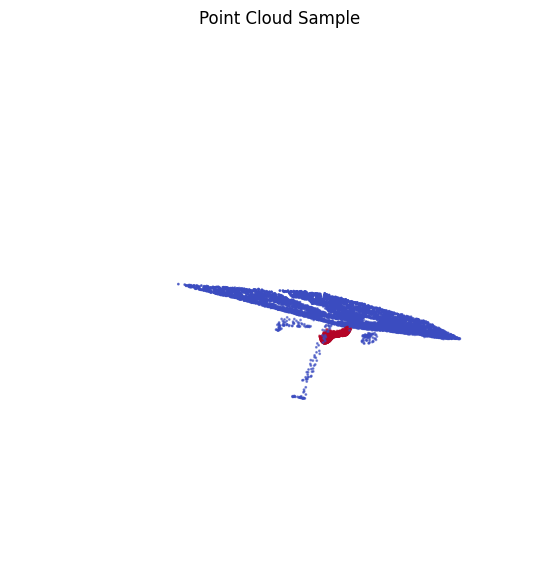

In [20]:
def visualize_sample(points, labels, title="Point Cloud Sample"):
    points = points.numpy()
    labels = labels.numpy()
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=labels, cmap="coolwarm", s=1)
    ax.set_title(title)
    ax.axis("off")
    plt.show()

visualize_sample(points, labels)
